# General instructions to complete the homework assignment


The purpose of the home work is to make use of neural network for the classification of metabolomics data associated with the following paper Cell 2020 Jul 9;182(1):59-72.e15. doi: 10.1016/j.cell.2020.05.032. Epub 2020 May 28. We recommend you read that paper.

In the paper the authors run metabolomics analysis on 47 CoViD-19 patients that just came to the hospital (Wuhan). They found out measuring metabolites and proteins concentrations that they could differentiate patients before they developed serere complications from benign ones. To find this out they used Random Forest with an accuracy on a test set of about 0.70

The goals of the homework project is to answer the following 2 questions:

1) Can we reach bettter performances (10 fold cross validation accuracies > 0.70) using metabolomics data only and using Artificial Neural Networks? 

2) Could an *E. coli* strain be engineered with no more than 4 biosensors such that the biosensors responses enable one to distinguished severe from non severe samples. 

Answering the first question is straigthforward as the datasets are found in the folder sent to you. Yet you will have to write a function that performs training for classification and x-fold cross validation. The section **Keras Utilities** already provide many fonctions to read and write datafiles, create dense ANN, and perform simple statistical calculations. After writting the classification routine we are asking you to use it to compute 10- and 5-fold cross validation accuracies on 1) the raw metabolomics data, and 2) on the data corresponding to metabolites that can cross *E. coli* cell membrane. To do this the main code is also provided in the section **Main Codes**, csv files are provided in the folder for the various datasets. An excel file is also provided summarizing all datasets with the actual names of the molecules.

Answering the second question is more complex. You will have first to run COBRA on an *E. coli* model (provided in the folder) modifying the medium with the metabolites found in the CoViD-19 samples. The **COBRA Utilities** section provide all the code to do that. Next, you will have to collect the production fluxes for 20 E. coli metabolites we know activate biosensors (the list is also provided in the folder). Finaly, using the production fluxes as input you will run the classification code written for question 1, and compute 10- and 5- fold cross validation accuracies. Engineering biosensors is a difficult task, and the fewer biosensors the better, so we are asking you to write a code that searches the combination of 4 metabolites (among the  20 provided) that maximizes cross validation accuracies.

Folder content and Tips:
- X.csv: The CoViD-19 raw data (all metabolite concentrations)
- X_exchange: CoViDd-19 normalized concentrations for metabolites crossing the cell membrane
- Y.csv: 1 severe, 0 bening cases
- Y_sensor_20: List of 20 *E coli* metabolites for which one can build a biosensor
- sbml_model_E_coli_iAF1260: *E. coli* model to be used by COBRA functions
- Data.xsl: excel file with several tabs compiling all data usde to generate the csv files
- Code to be written and modified are only in the **Classification** and **Main Code** sections

**Your Report:**

We are asking you to prepare a pdf file (with you name as the file name) reporting the following:
1. A copy of your **Classification** section (8 points)
2. 10- and 5- cross validation accuracies for the raw metabolomics data, and the data corresponding to metabolites that can cross *E. coli* cell membrane (2 points)
3. 10- and 5- cross validation accuracies obtained when training on the 20 *E. coli* given production fluxes generated by COBRA (2 points)
4. A copy of the code written to reduce the list of 20 fluxes down to 4, along with the 10- and 5- cross validation accuracies obtained (4 points)
5. A discussion of the results, commenting for each studied senario if one can we indeed distinguished severe from benign, if the predictions are reliabe, and briefly what does it take to implement the senario, i.e., perform metabolomics, used an engineered strain etc.. (4 points)

# Loading Libraries

Load all necessary libraries, numpy, pandas, keras, cobra (tensor flow is alredy there)

In [1]:
from __future__ import print_function

! pip install keras
! pip install cobra==0.17.1
! pip install silence_tensorflow

# Tensorflow might generate WARNINGS because of GPU unused, silence it
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import os
import sys
import csv
import random
import math
import numpy as np
import pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 KB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 88.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.3/555.3 KB 45.2 MB/s eta 0:00:00
  Created wheel for python-libsbml-experimental: filename=python_libsbml_experimental-5.18.0-cp38-cp38-linux_x86_64.whl size=70509919 sha256=e9401e772aea242cbca1d27d910f62fde05f53b76d21affe7f028b203a7baab3
  Stored in directory: /root/.cache/pip/wheels/8d/a3/78/a8c5c9a116c843f6c8d

# COBRA Utilities


Some utilities making use of CobraPy. Basically run COBRA for a given medium and compute production fluxes for a given set of molecules 

In [3]:
# COBRA utilities

import cobra
#import cobra.test
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import add_loopless, loopless_solution 
from cobra.flux_analysis import pfba

def read_out_flux_list(filename):
    # read outgoing fluxes found in filename
    # file format is: metabolite name, and other unsused parameters
    # Returns dictonary with name as key and zero value, OUT[metabolite name] = 0
    filename += '.csv'
    OUT = {}
    with open(filename) as h:
        for line in h:
            K = line.rstrip().split(',')
    for i in range(len(K)):
        OUT[K[i]] = 0
    return OUT

def write_training_set_cobra(DATA, filename, newfile = True):
    # Write DATA (a dictionay) in filename 
    # First line of the file contains the header (i.e., flux-names)
    # Subsequent lines are the values
    filename += '.csv'
    with open(filename, 'w') as h:
        data = DATA[0] # print header
        if newfile:
            h.write(','.join(str(k) for k in data.keys()))
            h.write('\n') 
        for n in DATA.keys(): # print values
            data = DATA[n]
            h.write(','.join(str(k) for k in data.values()))
            h.write('\n')

def read_training_set_cobra(filename):
    # Read DATA stored in filename, see above for file format
    # Return a dictionary DATA[name] = value
    filename += '.csv'
    DATA = {}; n = 0
    with open(filename) as h:
        lines = h.readlines()
        K = lines[0].rstrip().split(',')
        for n in range(1,len(lines)):
            V = lines[n].rstrip().split(','); data = {}
            for i in range(len(V)): data[K[i]] = V[i] 
            DATA[n-1] = data
    return DATA

def run_cobra(model,IN,OUT,verbose=False):
    # run FBA optimization to compute fluxes on the provided model
    # set the medium using values in dictionary IN
    # Returns a dictionary (FLUX) with the fluxes for 
    # the metabolites found in dictionary OUT

    # set the medium
    medium = model.medium # This is the model medium   
    for r in medium.keys():
        medium[r] = 10.0 # Allow to get some growth   
    for k in IN.keys(): # Additional cmpds added to medium
        medium[k] = float(IN[k])       
    model.medium = medium
    #print('medium=',medium)
    
    # run FBA
    solution = model.optimize()
    if verbose:
        print('objectif =',solution.objective_value)
    #model.summary()  
    
    # get the outgoing fluxes for cmpds listed in OUT
    FLUX = OUT.copy()
    for x in model.reactions:
        if solution.fluxes[x.id] != 0:
            for y in x.products:
                if y.id in FLUX.keys():
                    FLUX[y.id] += solution.fluxes[x.id]
    for y in FLUX.keys():
        if math.fabs(float(FLUX[y])) < 0.001: 
          # 10^-3 must be able to measure it
            FLUX[y] = 0
            
    # Reset additional cmpds added to the medium
    medium = model.medium
    for k in IN.keys():
        medium[k] = 0.0
    model.medium = medium
    
    return FLUX, solution


def create_output_training_set_cobra(OUT, INFLUX, cobrastrain=None, 
                                     cobrafile=None):
    # Run Cobra for a series of input fluxes in INFLUX 
    # names of outgoing fluxes are in OUT list
    # Get and return the fluxes for the metabolites in OUT
    if cobrastrain == None:
        if cobrafile == None:
            sys.exit('Error: Must provide a file for COBRA !')
        cobrastrain = cobra.io.read_sbml_model(cobrafile) 
    OUTFLUX = {}
    for n in range(len(INFLUX.keys())):
        OUTFLUX[n], solution = run_cobra(cobrastrain,INFLUX[n],OUT)
    return cobrastrain, OUTFLUX


# Keras Utilities

Utilities from Keras and sklearn. Read, write and format data, create model, get statistics including ROC curves 

In [80]:
# Learning and x-validation utilities using Keras and sklearn

import keras
#os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras.backend as K
from keras import initializers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input, Dense, LSTM, Dropout, Flatten
from keras.layers import Lambda, Reshape
from keras.layers import multiply, concatenate, add, subtract, dot
from keras.constraints import unit_norm, NonNeg
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

%matplotlib inline
import matplotlib.pyplot as plt

def scale(data):
    # standardize data
    scaler = MinMaxScaler()
    scaler.fit(data)
    return scaler.transform(data)

def read_training_data(filename):
    filename += '.csv'
    dataframe = pandas.read_csv(filename, header=0)
    dataset = dataframe.values
    DATA = np.asarray(dataset[:,:])
    return DATA

def read_XY(model_in, model_out):
    # Format date for training
    X = scale(read_training_data(model_in))
    Y = read_training_data(model_out)
    return X,Y

def write_training_results(R,filename):
    filename += '.csv'
    with open(filename, 'w') as h:
        # header
        h.write(','.join('res'+str(k) for k in range(R.shape[1]) ))
        h.write('\n')
        # data
        for i in range(0,R.shape[0]):
            h.write(','.join(str(R[i][k]) for k in range(R.shape[1])))
            h.write('\n')

class MODEL:
    def __init__(self, model, 
                 input_dim, output_dim, n_hidden, 
                 output_activation, dropout):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_hidden = n_hidden
        self.output_activation = output_activation
        self.dropout = dropout

def my_accuracy(y_true, y_pred):
    # binary accuracy
    return keras.metrics.binary_accuracy(y_true[:,0:1], y_pred[:,0:1])

def create_model(input_dim, output_dim, 
                 activation='sigmoid', 
                 n_hidden=1, dropout=0.1, 
                 loss='binary_crossentropy', metrics=['accuracy'],  
                 verbose=False):
    # Build and return a simple dense model. 
    inputs  = Input(shape=(input_dim,)) 
    hidden  = inputs
    hidden_dim=input_dim
    # Hiden layers
    for i in range(n_hidden):
        hidden    = Dense(hidden_dim, kernel_initializer='normal', 
                          activation='relu' ) (hidden) 
        hidden    = Dropout(dropout)(hidden) 
    # Output layer
    outputs = Dense(output_dim, kernel_initializer='normal', 
                    activation='sigmoid') (hidden)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
    print(model.summary())
    return MODEL(model, input_dim, output_dim, n_hidden, activation, dropout)

def ROC(X, Y, Network, xfold=10, epochs=1000, batch_size=10):
    # Plot a ROC curve using X, Y and a model Network
    test_size = 1.0 - 1.0/xfold # to get a ratio
    X_train, X_test, Y_train, Y_test = \
    train_test_split(X, Y, test_size=test_size)
    Network.model.fit(X_train, Y_train, epochs=epochs, 
                      batch_size=batch_size, verbose=False)
    Y_pred = Network.model.predict(X_test).ravel()


    testresult=my_accuracy(Y_test,Y_pred)
    #print(testresult)

    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    AUC = auc(fpr, tpr)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='(area = {:.3f})'.format(AUC))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

# Classification (to be written)

Code for classification you will have to write.

MAKE SURE YOU MAKE GOOD USE OF THE PARAMETER GIVEN AS INPUT

The code should return:
1. The model having the best cross validation accuracy
2. The Y values predicted by the model 
3. The average accuracy on cross validation sets
3. The stdev for accuracy

In [93]:
# Training Neural Network models for classification
def train_model_classification(X,Y, 
                               activation= 'sigmoid', 
                               loss = 'binary_crossentropy',
                               n_hidden=1, dropout=0.1,
                               epochs=100, batch_size=10,
                               niter=1, xfold=5, seed=10, 
                               verbose=True):
    # Please comment I/O here
    
    # Get model parameters 
    input_dim = X.shape[1]
    output_dim = Y.shape[1]
    hidden_dim = input_dim
    if verbose:
        print("Training size = %d input_dim = %d output_dim = %d hidden_dim = %d nbr_hidden = %d epochs = %d, batch_size= %d" 
              % (len(Y),input_dim, output_dim,
                 hidden_dim, n_hidden,
                 epochs, batch_size))
        
    
    # WRITE YOUR PIECE OF CODE HERE
    #Define MLP

    Network=create_model(input_dim, output_dim, 
                 activation='sigmoid', 
                 n_hidden=1, dropout=0.1, 
                 loss='binary_crossentropy', metrics=['accuracy'],  
                 verbose=False)
    
    print('input_dim',input_dim)
    model = Sequential()
    model.add(Dense(input_dim, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print(model.summary())

    # Import MLPClassifer 
    from sklearn.neural_network import MLPClassifier

    # Create model object
    clf = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=False,
                    learning_rate_init=0.01)
    

    # Fit data onto the model

    #mlp_result = cross_validation(clf, X, Y, xfold)
    #print(mlp_result)

    

    results=[]
    models=[]
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=10)
    for train_indices, test_indices in kf.split(X):

        #clf.fit(X[train_indices], Y[train_indices])
        Network.model.fit(X[train_indices], Y[train_indices], epochs=30, batch_size=10,verbose=0)

        #results.append(clf.score(X[test_indices], Y[test_indices]))
        res=Network.model.predict(X[test_indices])

        rounded = [round(x[0]) for x in res]
        #print(rounded)
        
       
        #print('predicted ===>',res)
        #rounded = [round(x[0]) for x in res]
        print('rounded ===>',rounded)
        
        
        print('actual ===>',Y[test_indices].ravel())
        print('Predicted',res)
        scores=Network.model.evaluate(X[test_indices], Y[test_indices])
        #results.append(scores[1] * 100)
        #scores=clf.score(X[test_indices], Y[test_indices])
        print("accuracy is: ",scores[1]* 100)
        


    #clf.fit(X_train,y_train)

    #ypred=clf.predict(X_test)


    # Instructions: repeat for all iteration
    # 1. Split train/test
    # 2. Create and train model
    # 3. Compute accuracy on test set
    # Return:
    # 1. The best model
    # 2. The predictions made by best model
    # 3. The average accuracy  
    # 4. The stdev on accuracy







#Main Code: Train for classification

The code below perform a simple classification on dataset X,Y.

Use this code to compute the cross validation accuracy 
1. On raw data
2. On a list of biomarkers concentration that can cross the membrane

In [94]:
# Standard classification main code


from google.colab import drive
drive.mount('/content/drive',force_remount=True)
dir = '/content/drive/My Drive/Metabolic/Dataset/'

# read and format data 
data_X = dir+'X' # or X_exchange
data_Y = dir+'Y'

X, Y = read_XY(data_X,data_Y)

# Classification parameters. Note that these can be changed 
n_hidden=1; dropout=0.1
epochs=1000; batch_size=10
niter=2; xfold = 10; seed = 1

# Classification 
result =train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=True)

#print(result)
#print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))

# Save results and plot ROC curve
#filename = data_Y + '_pred'
#write_training_results(Y_pred,filename)
#ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size)

Mounted at /content/drive
Training size = 47 input_dim = 941 output_dim = 1 hidden_dim = 941 nbr_hidden = 1 epochs = 1000, batch_size= 10
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 941)]             0         
                                                                 
 dense_144 (Dense)           (None, 941)               886422    
                                                                 
 dropout_26 (Dropout)        (None, 941)               0         
                                                                 
 dense_145 (Dense)           (None, 1)                 942       
                                                                 
Total params: 887,364
Trainable params: 887,364
Non-trainable params: 0
_________________________________________________________________
None
input_dim 941
1/1 [======================

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy as np
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load pima indians dataset
dataset = np.loadtxt("/content/drive/My Drive/Metabolic/Dataset/pima-indians-diabetes.data.csv", delimiter=",")
# split into input (X) and output (Y) variables
#X = dataset[:,0:8]
#Y = dataset[:,8]
data_X = dir+'X' # or X_exchange
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):


	# create model
 model = Sequential()
 model.add(Dense(12, input_dim=941, activation='relu'))
 model.add(Dense(8, activation='relu'))
 model.add(Dense(1, activation='sigmoid'))
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
 res2=model.predict(X[test])
 print('predict',res2)
 scores = model.evaluate(X[test], Y[test], verbose=0)
 print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
 cvscores.append(scores[1] * 100)
 print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

1/1 [==============================] - 0s 63ms/step
predict [[9.9881506e-01]
 [9.9906039e-01]
 [8.6608034e-01]
 [1.2071470e-01]
 [9.7964425e-04]]
accuracy: 100.00%
1/1 [==============================] - 0s 55ms/step
predict [[9.9990261e-01]
 [9.9999475e-01]
 [9.9975508e-01]
 [1.3800318e-04]
 [2.3231516e-03]]
accuracy: 100.00%
1/1 [==============================] - 0s 54ms/step
predict [[0.9944302 ]
 [0.98150253]
 [0.99901736]
 [0.02048893]
 [0.00641846]]
accuracy: 80.00%
1/1 [==============================] - 0s 57ms/step
predict [[0.83918595]
 [0.991876  ]
 [0.00126975]
 [0.07260592]
 [0.02587324]]
accuracy: 100.00%
1/1 [==============================] - 0s 48ms/step
predict [[9.9893498e-01]
 [9.9970078e-01]
 [1.0932484e-04]
 [2.5361931e-01]
 [6.2022358e-01]]
accuracy: 80.00%
1/1 [==============================] - 0s 49ms/step
predict [[0.961621  ]
 [0.5516396 ]
 [0.05031934]
 [0.01896926]
 [0.04472374]]
accuracy: 100.00%
1/1 [==============================] - 0s 54ms/step
predict [[9

In [14]:
Y

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [19]:
# Standard classification main code


from google.colab import drive
drive.mount('/content/drive',force_remount=True)
dir = '/content/drive/My Drive/UE_DoE_ML/'

# read and format data 
data_X = dir+'X' # or X_exchange
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)

# Classification parameters. Note that these can be changed 
n_hidden=1; dropout=0.1
epochs=1000; batch_size=10
niter=2; xfold = 10; seed = 1

# Classification 
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=True)
print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))

# Save results and plot ROC curve
filename = data_Y + '_pred'
write_training_results(Y_pred,filename)
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size)

Mounted at /content/drive


FileNotFoundError: ignored

# Main Code: Train with Cobra Reservoir

The code below first run COBRA with different media found in X_exchange to compute the production fluxes of the molecules listed in Y_sensor_20 and then perform a classification taking as input flux values (found in Y_COBRA. Therefore, the COBRA strain model is used as reservoir.  

Mounted at /content/drive
2/2 [==============================] - 0s 8ms/step
Acc = 0.95 (+/- 0.07)
2/2 [==============================] - 0s 4ms/step


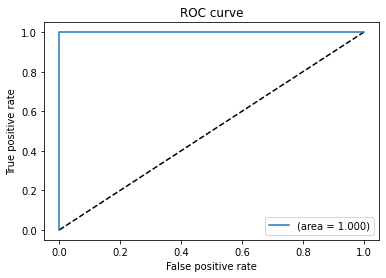

In [ ]:
# The classification take as input a set of biomarkers turned on running 
# COBRA on a wilde type strain
# Then COBRA output (Y_COBRA) to train a post ANN

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
dir = '/content/drive/My Drive/UE_DoE_ML/'
reservoir_in  = dir+'X_exchange' # Biomarker concentrations
                                 # crossing the membrane
reservoir_out = dir+'Y_COBRA'
list_out  = dir+'Y_sensor_20' # list of biosensors, 
                              # i.e. flux calculared by COBRA
cobrafile = dir+'sbml_model_E_coli_iAF1260.xml' 

# Generate the training set with COBRA, 
# running COBRA on given biomarker concentrations
IN =  read_training_set_cobra(reservoir_in)
list_out = read_out_flux_list(list_out)
strain, OUT = create_output_training_set_cobra(list_out, IN, cobrafile=cobrafile)
write_training_set_cobra(OUT, reservoir_out)
data_X = reservoir_out
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)

# Classification parameters
n_hidden=2; dropout=0.1
epochs=1000; batch_size=10
niter=10; xfold = 5; seed = 1

# Classification
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold, seed=seed, verbose=False)
print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))

# Save results and plot ROC curve
filename = data_Y + '_pred'
write_training_results(Y_pred,filename)
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size)

# Main Code: Search Minimum Number of Biosensors

Your work will be to write the code below to reduce the biosensor list to at most 4 fluxes while keeping the cross validation accuracy above 0.8. We provide two functions to help.

Mounted at /content/drive
2/2 [==============================] - 0s 6ms/step
Remove 14 MNXM105630@MNXC3 Acc = 0.94 (+/- 0.05) 
2/2 [==============================] - 0s 5ms/step
Remove 8 MNXM89557@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 6ms/step
Remove 0 MNXM1565@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 6ms/step
Remove 4 MNXM134@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 5ms/step
Remove 5 MNXM286@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 5ms/step
Remove 4 MNXM231@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 6ms/step
Remove 7 MNXM338@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 6ms/step
Remove 6 MNXM94@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 7ms/step
Remove 6 MNXM287@MNXC3 Acc = 0.96 (+/- 0.05) 
2/2 [==============================] - 0s 7ms/step
Remove 6 MNXM91@MNXC3 Acc = 0.94 (+/- 0.08) 

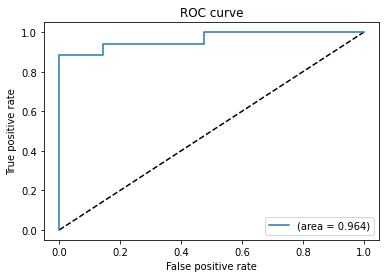

In [ ]:
def remove_column(X,j): 
  # remove column j from matrix X and return reduced matrix
  XX = np.zeros((X.shape[0], X.shape[1]-1), dtype=X.dtype)
  XX[:, :j] = X[:, :j]
  XX[:, j:] = X[:, j+1:]
  return(XX)

def remove_column_best(X,Y, n_hidden=2, dropout=0.1,
                      epochs=100, batch_size=10,niter=1, xfold=5,
                      seed=10, verbose=False):
  # search the column in X which once removed lead to the highest
  # x-validation accuracy
  N = X.shape[1]
  Acc_avr_best = 0
  column_best = -1
  for column in range(N):
    XX = remove_column(X,column)
    Network, Y_pred, Acc_avr, Acc_dev = \
    train_model_classification(XX, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold,
                           seed=seed, verbose=verbose)
    if Acc_avr > Acc_avr_best: 
      Acc_avr_best = Acc_avr
      Acc_dev_best = Acc_dev
      column_best = column
      X_best = XX
  return X_best, column_best, Acc_avr_best, Acc_dev_best

# Use the above functions to find a set of 4 fluxes that maximized 
# x-validation accuracy

from google.colab import drive
drive.mount('/content/drive',force_remount=True)
dir = '/content/drive/My Drive/UE_DoE_ML/'
reservoir_in  = dir+'X_exchange' # Biomarker concentrations
                                 # crossing the membrane
reservoir_out = dir+'Y_COBRA'
list_out  = dir+'Y_sensor_20' # list of biosensors, 
                              # i.e. flux calculared by COBRA
cobrafile = dir+'sbml_model_E_coli_iAF1260.xml' 

# Generate the training set with COBRA, 
# running COBRA on given biomarker concentrations
IN =  read_training_set_cobra(reservoir_in)
list_out = read_out_flux_list(list_out)
strain, OUT = create_output_training_set_cobra(list_out, IN, cobrafile=cobrafile)
write_training_set_cobra(OUT, reservoir_out)
data_X = reservoir_out
data_Y = dir+'Y'
X, Y = read_XY(data_X,data_Y)
SENSOR = list(list_out.keys())

# Remove column from X leading to the highest accuracy.
# WRITE YOUR CODE HERE:


# Save and plot ROC curve for final model
n_hidden=2; dropout=0.1
epochs=1000; batch_size=10
niter=1; xfold = 5; seed = 100
Network, Y_pred, Acc_avr, Acc_dev = \
train_model_classification(X, Y, n_hidden=n_hidden, dropout=dropout,
                           epochs=epochs, batch_size=batch_size,
                           niter=niter, xfold=xfold,
                           seed=seed, verbose=False)
print("SENSOR:",SENSOR)
print("Acc = %.2f (+/- %.2f)" % (Acc_avr, Acc_dev))
filename = data_Y + '_pred'
write_training_results(Y_pred,filename)
ROC(X,Y, Network, xfold=xfold, epochs=epochs, batch_size=batch_size)